# Capstone Project 3: Preprocessing & Modeling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
final_df = pd.read_csv('final_df.csv')
final_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df = final_df.copy()

## Preprocessing

In [5]:
# Separating the target from from other features

X = df.drop(columns='stroke')
y = df['stroke']

In [6]:
# Defining categorical and numerical columns

cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_cols = ['age', 'avg_glucose_level', 'bmi']


# ColumnTranformer for preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

In [7]:
# Fitting and transforming features
X_processed = preprocessor.fit_transform(X)

# New feature names
ohe_feat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
final_feat_names = num_cols + list(ohe_feat_names) + ['hypertension', 'heart_disease']

X_processed_df = pd.DataFrame(X_processed, columns=final_feat_names)

X_processed_df.head()

,age,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,hypertension,heart_disease
0,1.051434,2.706375,1.005086,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.786070,2.121559,-0.098981,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.626390,-0.005028,0.472536,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.255342,1.437358,0.719327,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.582163,1.501184,-0.631531,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [8]:
# Checking the numerical columns to see if they are properly scaled
# Should have mean ~ 0 and STD ~ 1
X_processed_df[num_cols].describe().T[['mean','std']]

,mean,std
age,5.005781e-17,1.000098
avg_glucose_level,1.001156e-16,1.000098
bmi,-4.449583e-17,1.000098


X has been successfully scaled and is ready for train-test-splitting.

**Train-test-splitting**

In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y, test_size=0.2, random_state=42, stratify=y 
)

# Before applying SMOTE
print('Stroke distribution in y_train:', Counter(y_train))

# After applying SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print('Balanced stroke distribution in y_train:', Counter(y_train_balanced))

Stroke distribution in y_train: Counter({0: 3889, 1: 199})
Balanced stroke distribution in y_train: Counter({0: 3889, 1: 3889})


In [10]:
# Reassigning balanced data back to X_train, y_train
X_train = X_train_balanced
y_train = y_train_balanced

## Modeling

In a medical setting it is important to catch as many true positive/reduce false negative stroke cases. 

So we will need to look to **recall** as our leading metric for model choice consideration.

We will look at each model's recall through the **training** and **testing** data.

### Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

log_param_grid = {
    'penalty':['l1','l2'],
    'C':[0.01,0.1,1,10,100],
    'solver':['liblinear'],
    'class_weight':[None, 'balanced']
}

# GridSearchCV
log_reg = LogisticRegression(max_iter=1000, random_state=42)
grid_log = GridSearchCV(log_reg, log_param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_log.fit(X_train, y_train)

# Best Model
log_model = grid_log.best_estimator_
print(f'Best Parameters: {grid_log.best_params_}')

Best Parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


**Logistic Model (training data)**

Logistic Regression Classification Report (Training):
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      3889
           1       0.75      0.85      0.79      3889

    accuracy                           0.78      7778
   macro avg       0.79      0.78      0.78      7778
weighted avg       0.79      0.78      0.78      7778

Logistic Regression Confusion Matrix (Training):
[[2761 1128]
 [ 587 3302]]
Logistic Regression ROC AUC Score (Training): 0.8458036562434772


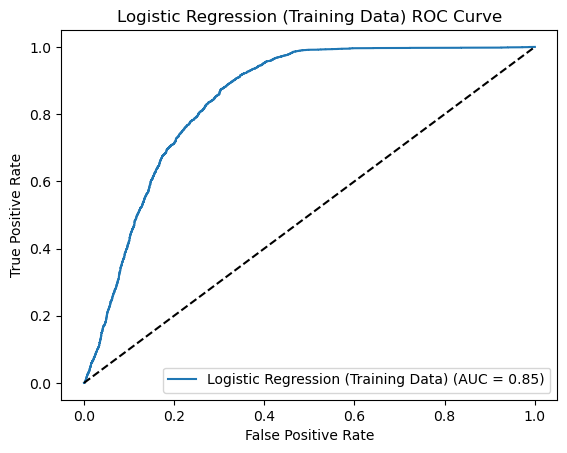

In [50]:
# Predictions from training data
y_pred_log_train = log_model.predict(X_train)
y_proba_log_train = log_model.predict_proba(X_train)[:,1]

# Saving logistic model (training) metrics
log_class_rep_train = classification_report(y_train, y_pred_log_train, output_dict=True)
log_stroke_recall_train = log_class_rep_train['1']['recall']
log_roc_auc_train = roc_auc_score(y_train, y_proba_log_train)

# Evaluating model with training data
print('Logistic Regression Classification Report (Training):')
print(classification_report(y_train, y_pred_log_train))
print('Logistic Regression Confusion Matrix (Training):')
print(confusion_matrix(y_train, y_pred_log_train))
print(f'Logistic Regression ROC AUC Score (Training): {log_roc_auc_train}')

# Plotting ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_proba_log_train)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (Training Data) (AUC = {:.2f})'.format(roc_auc_score(y_train, y_proba_log_train)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression (Training Data) ROC Curve')
plt.legend()
plt.show()

**Logistic Model (testing) data**

Logistic Model Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.82      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.95      0.73      0.81      1022

Logistic Model Confusion Matrix (Testing Data)
[[706 266]
 [  9  41]]
Logistic ROC AUC Score (Testing Data): 0.8402057613168724


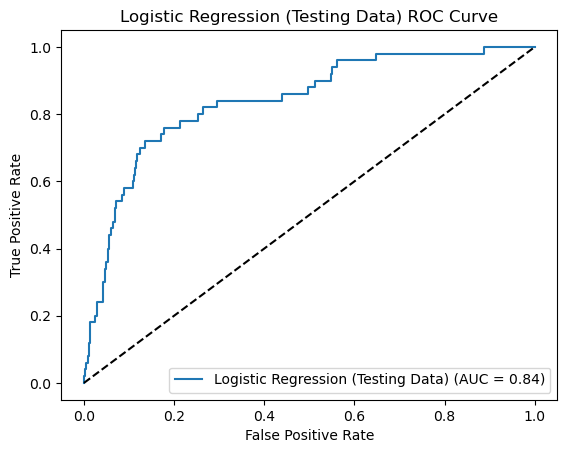

In [51]:
# y_pred for logistic model testing data
y_pred_log_test = log_model.predict(X_test)
y_proba_log_test = log_model.predict_proba(X_test)[:,1]

# Saving metrics for logistic model testing data
log_class_rep_test = classification_report(y_test, y_pred_log_test, output_dict=True)
log_stroke_recall_test = log_class_rep_test['1']['recall']
log_roc_auc_test = roc_auc_score(y_test, y_proba_log_test)

# Evaluating model with testing data
print('Logistic Model Classification Report (Testing Data):')
print(classification_report(y_test, y_pred_log_test))
print('Logistic Model Confusion Matrix (Testing Data)')
print(confusion_matrix(y_test, y_pred_log_test))
print(f'Logistic ROC AUC Score (Testing Data): {log_roc_auc_test}')

# Plotting ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_log_test)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (Testing Data) (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_log_test)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression (Testing Data) ROC Curve')
plt.legend()
plt.show()

In [52]:
log_model

LogisticRegression(C=0.01, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Parameter Grid for tuning
param_grid_rf = {
    'n_estimators':[50,75],
    'max_depth':[3,5],
    'min_samples_split':[20,40,60],
    'min_samples_leaf':[10,20,30],
    'max_features': ['sqrt', 0.2,0.3],
    'max_leaf_nodes': [10,20,30]
}

# Grid Search
rf_cl = RandomForestClassifier(random_state=42, 
                               class_weight='balanced', 
                               oob_score=True,
                              max_samples=0.3,
                              bootstrap=True)
grid_rf = GridSearchCV(rf_cl, 
                       param_grid_rf, 
                       cv=5, 
                       scoring='recall', 
                       n_jobs=-1,
                      verbose=1)
grid_rf.fit(X_train, y_train)

# Best model evaluation
rf_model = grid_rf.best_estimator_
print(f'Best Parameters: {grid_rf.best_params_}')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'max_depth': 5, 'max_features': 0.2, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 60, 'n_estimators': 50}


**Random Forest (training data)**

Random Forest (Training Data) Confusion matrix:
[[2785 1104]
 [ 169 3720]]
Random Forest (Training Data) Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.81      3889
           1       0.77      0.96      0.85      3889

    accuracy                           0.84      7778
   macro avg       0.86      0.84      0.83      7778
weighted avg       0.86      0.84      0.83      7778

ROC AUC Score: 0.933703932890607


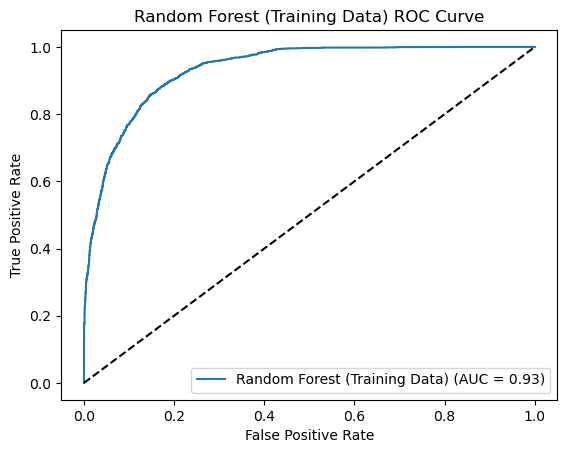

In [36]:
# Random Forest training data predictions
y_pred_rf_train = rf_model.predict(X_train)
y_proba_rf_train = rf_model.predict_proba(X_train)[:,1]

# Saving Random Forest model (training) metrics
rf_class_rep_train = classification_report(y_train, y_pred_rf_train, output_dict=True)
rf_stroke_recall_train = rf_class_rep_train['1']['recall']
rf_roc_auc_train = roc_auc_score(y_train, y_proba_rf_train)

# Evaluation with RF training data
print('Random Forest (Training Data) Confusion matrix:')
print(confusion_matrix(y_train, y_pred_rf_train))
print(f'Random Forest (Training Data) Classification Report:')
print(classification_report(y_train, y_pred_rf_train))
print(f'ROC AUC Score: {rf_roc_auc_train}')

# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, y_proba_rf_train)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (Training Data) (AUC = {:.2f})'.format(roc_auc_score(y_train, y_proba_rf_train)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest (Training Data) ROC Curve')
plt.legend()
plt.show()

**Random Forest (testing data)**

Random Forest (Testing Data) Confusion matrix:
[[701 271]
 [ 10  40]]
Random Forest (Testing Data) Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       972
           1       0.13      0.80      0.22        50

    accuracy                           0.73      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.73      0.80      1022

Random Forest (Testing Data) ROC AUC Score: 0.8171502057613169


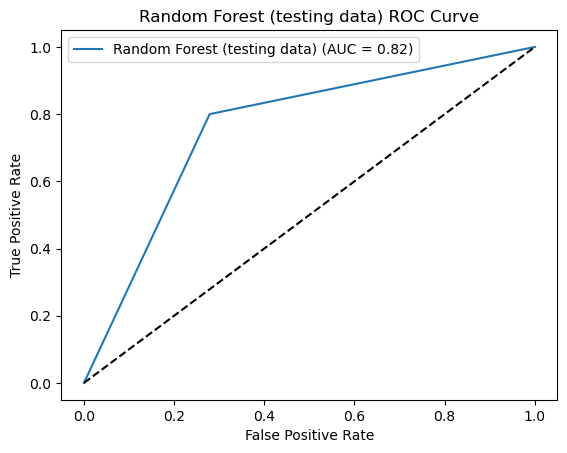

In [37]:
# Random Forest training data predictions
y_pred_rf_test = rf_model.predict(X_test)
y_proba_rf_test = rf_model.predict_proba(X_test)[:,1]

# Saving Random Forest model (testing) metrics
rf_class_rep_test = classification_report(y_test, y_pred_rf_test, output_dict=True)
rf_stroke_recall_test = rf_class_rep_test['1']['recall']
rf_roc_auc_test = roc_auc_score(y_test, y_proba_rf_test)

# Evaluation with RF testing data
print('Random Forest (Testing Data) Confusion matrix:')
print(confusion_matrix(y_test, y_pred_rf_test))
print('Random Forest (Testing Data) Classification Report:')
print(classification_report(y_test, y_pred_rf_test))
print(f'Random Forest (Testing Data) ROC AUC Score: {rf_roc_auc_test}')

# Plotting Random Forest (training) ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_test)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (testing data) (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_rf_test)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest (testing data) ROC Curve')
plt.legend()
plt.show()

In [38]:
rf_model

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.2,
                       max_leaf_nodes=20, max_samples=0.3, min_samples_leaf=10,
                       min_samples_split=60, n_estimators=50, oob_score=True,
                       random_state=42)

## LightGBM

**Initializing and tuning the model**

In [44]:
import lightgbm as lgb

# Param Grid for Gradient Boosting
param_grid_lgb = {
    'n_estimators':[50,100],
    'learning_rate': [0.05,0.1],
    'num_leaves': [15,25],
    'max_depth': [3,4],
    'min_child_samples': [20,30],
    'subsample': [0.6,0.8],
    'reg_alpha': [0,0.1],
    'reg_lambda': [0,0.1]
}

# Setting up model and running CV
lgb_clf = lgb.LGBMClassifier(random_state=42, 
                             class_weight='balanced',
                             subsample=0.8,
                             colsample_bytree=0.8)
grid_lgb = GridSearchCV(lgb_clf, 
                        param_grid_lgb, 
                        cv=5, 
                        scoring='recall', 
                        n_jobs=-1,
                       verbose=1)
grid_lgb.fit(X_train, y_train)

# Best model evaluation
lgb_model = grid_lgb.best_estimator_
print(f'Best Parameters: {grid_lgb.best_params_}')

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3889, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3322
[LightGBM] [Info] Number of data points in the train set: 7778, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

**LGBM (training data)**

Confusion matrix (LGB Training):
[[2965  924]
 [ 131 3758]]
Classification Report (LGB Training):
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      3889
           1       0.80      0.97      0.88      3889

    accuracy                           0.86      7778
   macro avg       0.88      0.86      0.86      7778
weighted avg       0.88      0.86      0.86      7778

ROC AUC Score (LGB Training): 0.9595602341420816


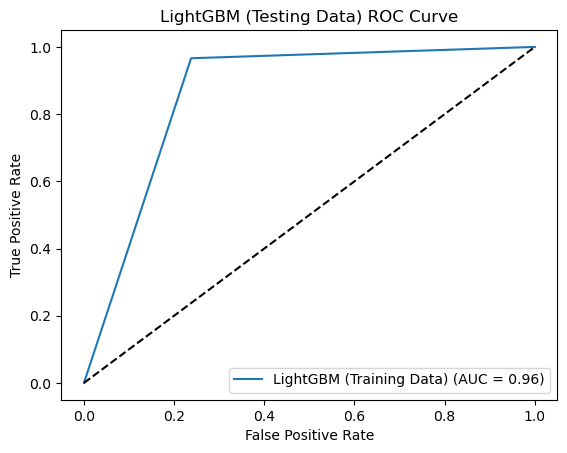

In [45]:
# LGBM (training) predictor values
y_pred_lgb_train = lgb_model.predict(X_train)
y_proba_lgb_train = lgb_model.predict_proba(X_train)[:,1]

# Saving LightGBM model (training) metrics
lgb_class_rep_train = classification_report(y_train, y_pred_lgb_train, output_dict=True)
lgb_stroke_recall_train = lgb_class_rep_train['1']['recall']
lgb_roc_auc_train = roc_auc_score(y_train, y_proba_lgb_train)

# Evaluation
print('Confusion matrix (LGB Training):')
print(confusion_matrix(y_train, y_pred_lgb_train))
print('Classification Report (LGB Training):')
print(classification_report(y_train, y_pred_lgb_train))
print(f'ROC AUC Score (LGB Training): {lgb_roc_auc_train}')

# Plotting Random Forest (training) ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_lgb_train)
plt.figure()
plt.plot(fpr, tpr, label='LightGBM (Training Data) (AUC = {:.2f})'.format(roc_auc_score(y_train, y_proba_lgb_train)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM (Testing Data) ROC Curve')
plt.legend()
plt.show()

**LGBM (Testing Data)**

Confusion matrix (LGB Testing):
[[744 228]
 [ 12  38]]
Classification Report (LGB Testing):
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       972
           1       0.14      0.76      0.24        50

    accuracy                           0.77      1022
   macro avg       0.56      0.76      0.55      1022
weighted avg       0.94      0.77      0.83      1022

ROC AUC Score (LGB Testing): 0.8305144032921811


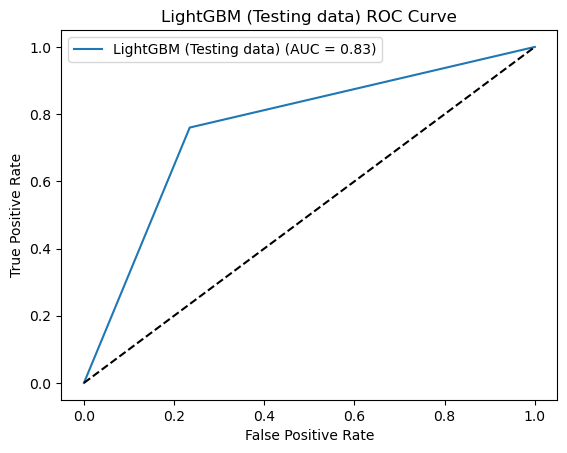

In [46]:
# LGBM (testing) predictor values
y_pred_lgb_test = lgb_model.predict(X_test)
y_proba_lgb_test = lgb_model.predict_proba(X_test)[:,1]

# Saving LightGBM model (testing) metrics
lgb_class_rep_test = classification_report(y_test, y_pred_lgb_test, output_dict=True)
lgb_stroke_recall_test = lgb_class_rep_test['1']['recall']
lgb_roc_auc_test = roc_auc_score(y_test, y_proba_lgb_test)

# Evaluation
print('Confusion matrix (LGB Testing):')
print(confusion_matrix(y_test, y_pred_lgb_test))
print('Classification Report (LGB Testing):')
print(classification_report(y_test, y_pred_lgb_test))
print(f'ROC AUC Score (LGB Testing): {lgb_roc_auc_test}')

# Plotting Random Forest (training) ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb_test)
plt.figure()
plt.plot(fpr, tpr, label='LightGBM (Testing data) (AUC = {:.2f})'.format(lgb_roc_auc_test))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM (Testing data) ROC Curve')
plt.legend()
plt.show()

In [47]:
lgb_model

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, max_depth=4, n_estimators=50, num_leaves=15,
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.6)

## Model Performance Overview

In [53]:
model_metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM'],
    'Recall (Stroke, Training)': [log_stroke_recall_train, rf_stroke_recall_train, lgb_stroke_recall_train],
    'Recall (Stroke, Testing)':[log_stroke_recall_test, rf_stroke_recall_test, lgb_stroke_recall_test],
})

model_metrics_df

,Model,"Recall (Stroke, Training)","Recall (Stroke, Testing)"
0,Logistic Regression,0.849061,0.82
1,Random Forest,0.956544,0.80
2,LightGBM,0.966315,0.76


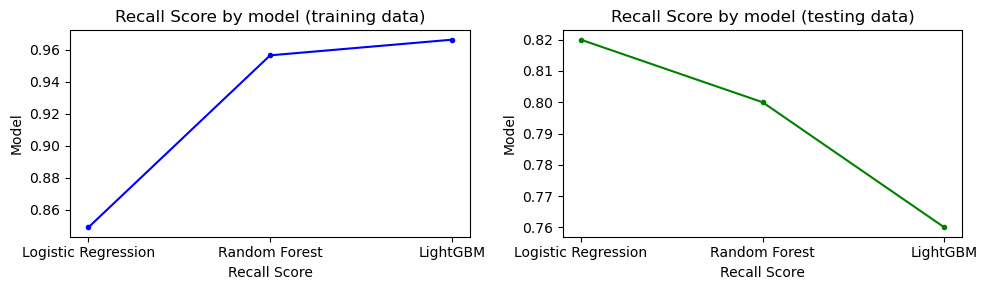

In [54]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(model_metrics_df['Model'], model_metrics_df['Recall (Stroke, Training)'], '.', linestyle='-', color='blue')
ax[0].set_xlabel('Recall Score')
ax[0].set_ylabel('Model')
ax[0].set_title('Recall Score by model (training data)')

ax[1].plot(model_metrics_df['Model'], model_metrics_df['Recall (Stroke, Testing)'], '.', linestyle='-', color='green')
ax[1].set_xlabel('Recall Score')
ax[1].set_ylabel('Model')
ax[1].set_title('Recall Score by model (testing data)')

plt.savefig('model_recall_comparisons.jpg')
plt.tight_layout()
plt.show()

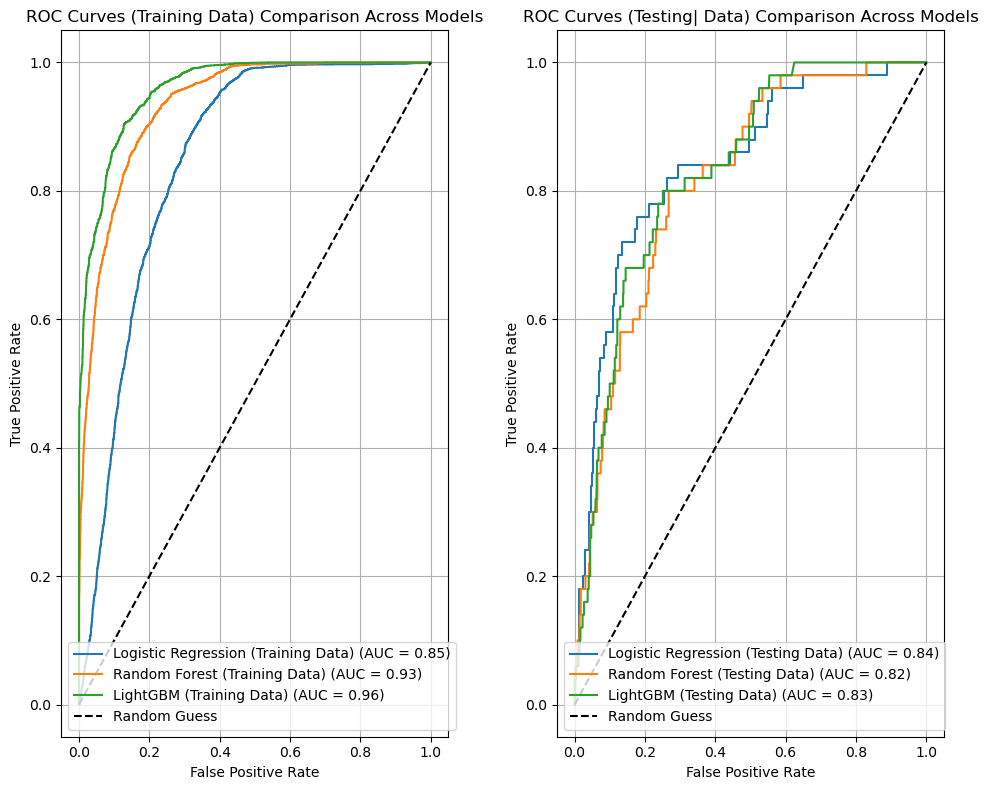

In [55]:
# Plotting ROC curves
fig, ax = plt.subplots(1, 2, figsize=(10,8))

# Training ROCs
fpr_log_tr, tpr_log_tr, _ = roc_curve(y_train, y_proba_log_train)
fpr_rf_tr, tpr_rf_tr, _ = roc_curve(y_train, y_proba_rf_train)
fpr_gb_tr, tpr_gb_tr, _ = roc_curve(y_train, y_proba_lgb_train)

ax[0].plot(fpr_log_tr, tpr_log_tr, label=f"Logistic Regression (Training Data) (AUC = {log_roc_auc_train:.2f})")
ax[0].plot(fpr_rf_tr, tpr_rf_tr, label=f"Random Forest (Training Data) (AUC = {rf_roc_auc_train:.2f})")
ax[0].plot(fpr_gb_tr, tpr_gb_tr, label=f"LightGBM (Training Data) (AUC = {lgb_roc_auc_train:.2f})")
ax[0].plot([0, 1], [0, 1], 'k--', label="Random Guess")
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curves (Training Data) Comparison Across Models')
ax[0].legend()
ax[0].grid(True)


# Testing ROCs
fpr_log_ts, tpr_log_ts, _ = roc_curve(y_test, y_proba_log_test)
fpr_rf_ts, tpr_rf_ts, _ = roc_curve(y_test, y_proba_rf_test)
fpr_gb_ts, tpr_gb_ts, _ = roc_curve(y_test, y_proba_lgb_test)

ax[1].plot(fpr_log_ts, tpr_log_ts, label=f"Logistic Regression (Testing Data) (AUC = {log_roc_auc_test:.2f})")
ax[1].plot(fpr_rf_ts, tpr_rf_ts, label=f"Random Forest (Testing Data) (AUC = {rf_roc_auc_test:.2f})")
ax[1].plot(fpr_gb_ts, tpr_gb_ts, label=f"LightGBM (Testing Data) (AUC = {lgb_roc_auc_test:.2f})")
ax[1].plot([0, 1], [0, 1], 'k--', label="Random Guess")
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curves (Testing| Data) Comparison Across Models')
ax[1].legend()
ax[1].grid(True)

plt.savefig('model_roc_curve_comparisons.jpg')
plt.tight_layout()
plt.show()

- All 3 models' **recalls** peform very well. Random Forest and LightGBM's recalls are both the highest for training, but look to be overfitting as they are both at leas 0.95.
- Testing data recalls lower with RF and LGB's being the lowest compared to Logistic's as it's model stays consistent. 
- All 3 models' **ROC AUC** are high performing for training and testing data, with the RF and LGB's training scores being at least 0.93 and their testing scores slightly below the Logistic Regression model's.
- The **Logistic Regression** will be our model of choice due to it's consistent performance across the training and testing data for it's **recall** and **ROC AUC**. The other 2 do perform well, but their high recall and ROC-AUC training data scores suggest that they may still be prone to overfitting.

In [56]:
# Saving model metric file
import csv

with open('models_metrics.csv', 'w', newline="") as f:
    writer = csv.writer(f)
    writer.writerow(['Model', 'Recall (stroke, training)', 'Recall (stroke, testing)'])
    writer.writerow(['Logistic Regression', log_stroke_recall_train, log_stroke_recall_test])
    writer.writerow(['Random Forest', rf_stroke_recall_train, rf_stroke_recall_test])
    writer.writerow(['LightGBM', lgb_stroke_recall_train, lgb_stroke_recall_test])

In [57]:
model_metrics = pd.read_csv('models_metrics.csv')
model_metrics

,Model,"Recall (stroke, training)","Recall (stroke, testing)"
0,Logistic Regression,0.849061,0.82
1,Random Forest,0.956544,0.80
2,LightGBM,0.966315,0.76


In [58]:
# Saving model
import joblib

joblib.dump(log_model, 'logistic_model_stroke_predictions.pkl')

['logistic_model_stroke_predictions.pkl']

## Feature importance

Although we have chosen our model, let's take a look at feature importance comparisons between the 3 models for future consideration.

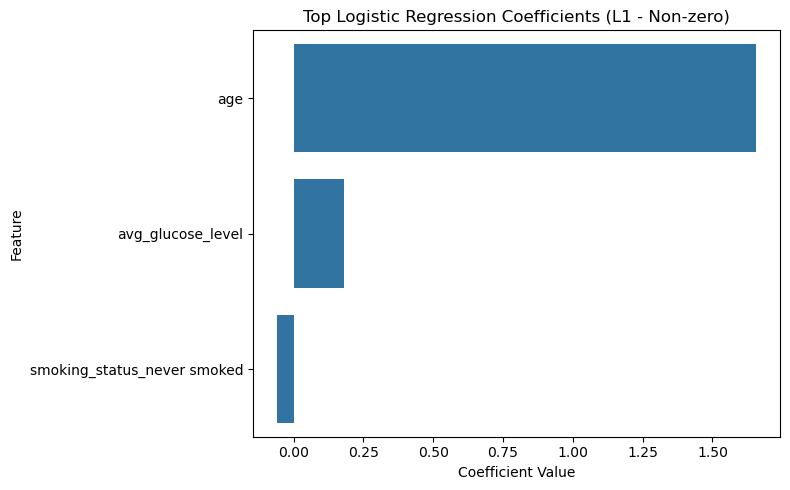

In [29]:
# For the logistic regression model, we will need to look for the nono-zero coefficients

# Non-zero coefficients
coefficients = pd.Series(log_model.coef_[0], index=X_train.columns)
non_zero_coeffs = coefficients[coefficients != 0].sort_values(key=np.abs, ascending=False)

# Plotting the feature importances
plt.figure(figsize=(8,5))
sns.barplot(x=non_zero_coeffs.values, y=non_zero_coeffs.index)
plt.title('Top Logistic Regression Coefficients (L1 - Non-zero)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('log_non_zero_coefs.jpg')
plt.show() 

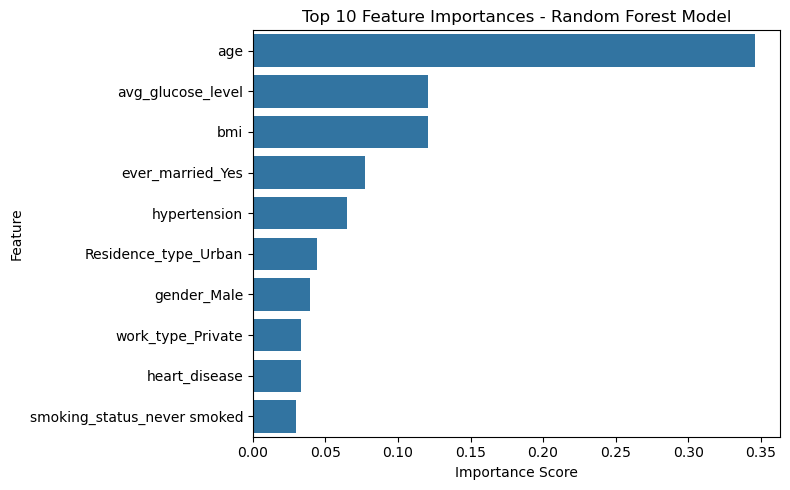

In [31]:
# Feature importances for Random Forest
feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_features_rf = feature_importances_rf.sort_values(ascending=False).head(10)

# Plotting the feature importances
plt.figure(figsize=(8,5))
sns.barplot(x=top_features_rf.values, y=top_features_rf.index)
plt.title('Top 10 Feature Importances - Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('rf_top10_feats.jpg')
plt.show()

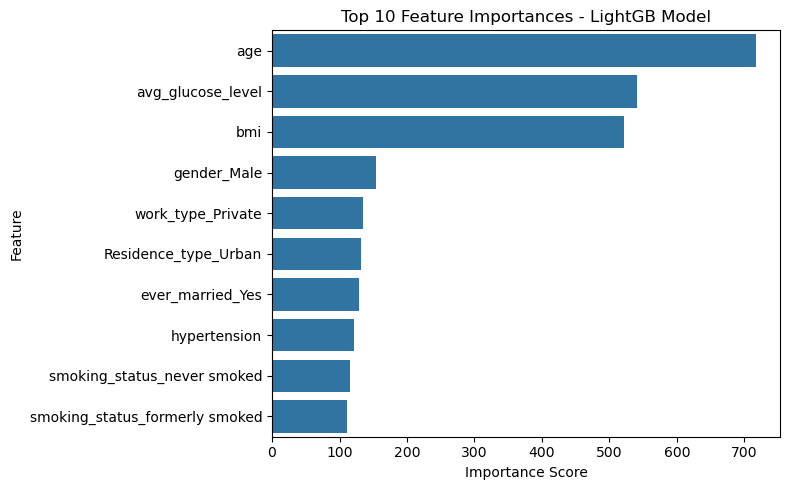

In [32]:
# Feature importances for LightGBM
feature_importances_lgb = pd.Series(lgb_model.feature_importances_, index=X_train.columns)
top_features_lgb = feature_importances_lgb.sort_values(ascending=False).head(10)

# Plotting the feature importances
plt.figure(figsize=(8,5))
sns.barplot(x=top_features_lgb.values, y=top_features_lgb.index)
plt.title('Top 10 Feature Importances - LightGB Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('gb_top10_feats.jpg')
plt.show()

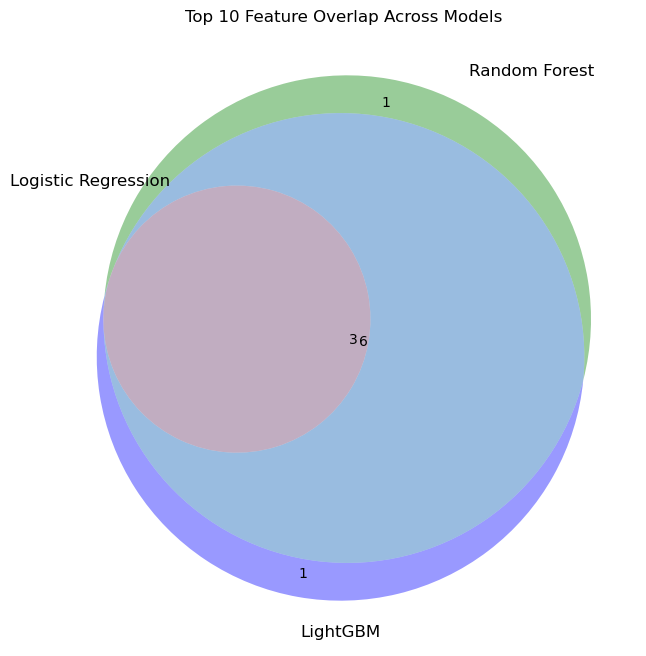

{'log_reg_top10': ['age', 'avg_glucose_level', 'smoking_status_never smoked'],
 'rf_top10': age                            0.346011
 avg_glucose_level              0.120777
 bmi                            0.120688
 ever_married_Yes               0.076938
 hypertension                   0.064570
 Residence_type_Urban           0.044227
 gender_Male                    0.039392
 work_type_Private              0.033368
 heart_disease                  0.033260
 smoking_status_never smoked    0.029637
 dtype: float64,
 'gb_top10': age                               717
 avg_glucose_level                 541
 bmi                               521
 gender_Male                       154
 work_type_Private                 135
 Residence_type_Urban              132
 ever_married_Yes                  129
 hypertension                      122
 smoking_status_never smoked       116
 smoking_status_formerly smoked    111
 dtype: int32}

In [34]:
# Venn Diagram for comparing top features across the models
from matplotlib_venn import venn3

log_reg_top10 = coefficients[coefficients != 0].abs().sort_values(ascending=False).head(10).index.tolist()
rf_top10 = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10).index.tolist()
lgb_top10 = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10).index.tolist()

plt.figure(figsize=(10,8))

venn3(
    [set(log_reg_top10), set(rf_top10), set(lgb_top10)],
    set_labels=('Logistic Regression', 'Random Forest', 'LightGBM')
)
plt.title('Top 10 Feature Overlap Across Models')
plt.show()

overlap_sets = {
    'log_reg_top10': log_reg_top10,
    'rf_top10': top_features_rf,
    'gb_top10': top_features_lgb
}

overlap_sets

**Age** and **avg_glucose_level** are the strongest predictors of stroke risk across all 3 models.